# PINN codes for Navier stokes and the heat equation

Prathvik G S

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib as mpl 

# 2D Navier stokes equations along with boundary conditions and incompressibility

$$u \frac{\partial{u}}{\partial{x}}+v\frac{\partial{u}}{\partial{y}}=-\frac{1}{\rho}\frac{\partial{p}}{\partial{x}}+\nu(\frac{\partial^2{u}}{\partial{x^2}}+\frac{\partial^2{u}}{\partial{y^2}})$$

$$u \frac{\partial{v}}{\partial{x}}+v\frac{\partial{v}}{\partial{y}}=-\frac{1}{\rho}\frac{\partial{p}}{\partial{y}}+\nu(\frac{\partial^2{v}}{\partial{x^2}}+\frac{\partial^2{v}}{\partial{y^2}})$$

$$\frac{\partial{u}}{\partial{x}}+\frac{\partial{v}}{\partial{y}}=0$$

$$u(x,y)=g(x,y): (x,y) \epsilon d\Omega$$

# The architecture

In [2]:
tf.keras.backend.set_floatx('float32')

#Define the neural network
model = tf.keras.Sequential([
    tf.keras.layers.Dense(20, activation='tanh', input_shape=(2,)),
    tf.keras.layers.Dense(20, activation='tanh'),
     tf.keras.layers.Dense(20, activation='tanh'),
     tf.keras.layers.Dense(20, activation='tanh'),
    tf.keras.layers.Dense(3)
])

# Custom loss function describing the Navier stokes eqn with boundary conditions and incompressibility

In [7]:
# Define the loss function using auto differentiation
def loss(xy,xyb):
    with tf.GradientTape(persistent=True) as tape:
        
        x,y=tf.unstack(xy,axis=1)
        tape.watch(x)
        tape.watch(y)
        
        u = model(tf.stack((x,y),axis=1))
        u_pred,v_pred,p_pred=tf.unstack(u,axis=1)
        
        dudx=tape.gradient(u_pred,x)
        dudy=tape.gradient(u_pred,y)
        
        dvdx=tape.gradient(v_pred,x)
        dvdy=tape.gradient(v_pred,y)
        
        dpdx=tape.gradient(p_pred,x)
        dpdy=tape.gradient(p_pred,y)
        
        d2udx2=tape.gradient(dudx,x)
        d2udy2=tape.gradient(dudy,y)
        
        d2vdx2=tape.gradient(dvdx,x)
        d2vdy2=tape.gradient(dvdy,y)
        
        xb,yb=tf.unstack(xyb,axis=1)
        ub = model(tf.stack((xb,yb),axis=1))
        u_predb,v_predb,p_predb=tf.unstack(ub,axis=1)
        
    loss = tf.reduce_mean(tf.square(u_pred*dudx+v_pred*dudy+dpdx-d2udx2-d2udy2))+\
           tf.reduce_mean(tf.square(u_pred*dvdx+v_pred*dvdy+dpdy-d2vdx2-d2vdy2))+\
           tf.reduce_mean(tf.square(dudx+dvdy))
    
    lossb=tf.reduce_mean(tf.square(u_predb-(1-np.e**(xb)*np.cos(2*np.pi*yb))))+\
          tf.reduce_mean(tf.square(v_predb-((0.5/np.pi)*np.e**(xb)*np.sin(2*np.pi*yb))))
    
    
    return loss/100 + lossb

In [12]:
# Define the grid size
N = 100
x_0=-1
x_L=1
y_0=-1
y_L=1

# Define the coordinates of the grid points
x = np.linspace(x_0, x_L, N)
y = np.linspace(y_0, y_L, N)

# Evaluate the electric field at the grid points
nx, ny = np.meshgrid(x, y, indexing='ij')
nx1=np.reshape(nx,-1)
ny1=np.reshape(ny,-1)
nxny = np.concatenate([nx1[:, None], ny1[:, None]], axis=1)
nx2ny2=tf.convert_to_tensor(nxny, dtype=tf.float32, dtype_hint=None, name=None)

In [13]:
# Define the coordinates of the grid points

'boundary-1'
x = np.linspace(x_0, x_0, 1)
y = np.linspace(y_0, y_L, 100)
nx, ny = np.meshgrid(x, y, indexing='ij')
nx1=np.reshape(nx,-1)
ny1=np.reshape(ny,-1)
nxny1 = np.concatenate([nx1[:, None], ny1[:, None]], axis=1)

'boundary-2'
x = np.linspace(x_L, x_L, 1)
y = np.linspace(y_0, y_L, 100)
nx, ny = np.meshgrid(x, y, indexing='ij')
nx1=np.reshape(nx,-1)
ny1=np.reshape(ny,-1)
nxny2 = np.concatenate([nx1[:, None], ny1[:, None]], axis=1)

'boundary-3'
x = np.linspace(x_0, x_L, 100)
y = np.linspace(y_0, y_0, 1)
nx, ny = np.meshgrid(x, y, indexing='ij')
nx1=np.reshape(nx,-1)
ny1=np.reshape(ny,-1)
nxny3 = np.concatenate([nx1[:, None], ny1[:, None]], axis=1)

'boundary-4'
x = np.linspace(x_0,x_L, 100)
y = np.linspace(y_L, y_L, 1)
nx, ny = np.meshgrid(x, y, indexing='ij')
nx1=np.reshape(nx,-1)
ny1=np.reshape(ny,-1)
nxny4 = np.concatenate([nx1[:, None], ny1[:, None]], axis=1)

nxnyb=np.concatenate([nxny1,nxny2,nxny3,nxny4],axis=0)
nxbnyb=tf.convert_to_tensor(nxnyb, dtype=tf.float32, dtype_hint=None, name=None)

In [18]:
# Define the optimizer

optimizer = tf.keras.optimizers.Adam()

# Train the model
for epoch in range(3000):
    with tf.GradientTape() as tape:
        loss_value = loss(nx2ny2,nxbnyb)
    grads = tape.gradient(loss_value, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))
    if epoch % 100 == 0:
        print(f"Epoch {epoch}, loss={loss_value:.6f}")


Epoch 0, loss=0.022499
Epoch 100, loss=0.022271
Epoch 200, loss=0.021944
Epoch 300, loss=0.021555
Epoch 400, loss=0.021123
Epoch 500, loss=0.020659
Epoch 600, loss=0.020176
Epoch 700, loss=0.019669
Epoch 800, loss=0.019158
Epoch 900, loss=0.018638
Epoch 1000, loss=0.018118
Epoch 1100, loss=0.017588
Epoch 1200, loss=0.017065
Epoch 1300, loss=0.016532
Epoch 1400, loss=0.016006
Epoch 1500, loss=0.015479
Epoch 1600, loss=0.014971
Epoch 1700, loss=0.014498
Epoch 1800, loss=0.014032
Epoch 1900, loss=0.013609
Epoch 2000, loss=0.013212
Epoch 2100, loss=0.012844
Epoch 2200, loss=0.012508
Epoch 2300, loss=0.012184
Epoch 2400, loss=0.011936
Epoch 2500, loss=0.011597
Epoch 2600, loss=0.011360
Epoch 2700, loss=0.011085
Epoch 2800, loss=0.010848
Epoch 2900, loss=0.010638


In [21]:
# Define the coordinates of the grid points
x = np.linspace(x_0, x_L, N)
y = np.linspace(y_0, y_L, N)

# Evaluate the electric field at the grid points
nx, ny = np.meshgrid(x, y, indexing='ij')
nx, ny = np.meshgrid(x, y, indexing='ij')
nx1=np.reshape(nx,-1)
ny1=np.reshape(ny,-1)
nxny = np.concatenate([nx1[:, None], ny1[:, None]], axis=1)

X=model(nxny)
u,v,p=tf.unstack(X,axis=1)

# PINN model solution

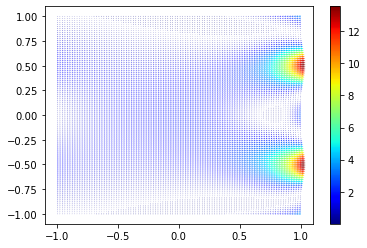

In [22]:
x_t,y_t=tf.unstack((nxny),axis=1)
M=(u*u+v*v)
qq=plt.quiver(x_t,y_t,u,v,M,cmap=plt.cm.jet)
plt.colorbar(qq, cmap=plt.cm.jet)
plt.show()

# Analytical solution

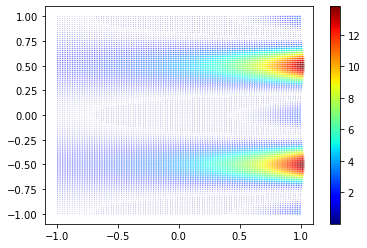

In [23]:
uu=1-np.e**(x_t)*np.cos(2*np.pi*y_t) 
vv=(0.5/np.pi)*(np.exp(x_t)*np.sin(2*np.pi*y_t))
M=(uu*uu+vv*vv)
qq=plt.quiver(x_t,y_t,uu,vv,M,cmap=plt.cm.jet)
plt.colorbar(qq, cmap=plt.cm.jet)
plt.show()

# Heat equation

$$ \frac{\partial{^2T}}{\partial{x^2}}+\frac{\partial^2{T}}{\partial{y^2}}=0$$

$$T(x=0)=100^o$$

$$T(x=L)=-100^o$$

$$T(x=0)=0^o$$

$$T(x=0)=0^o$$

In [24]:
#Define the neural network architecture- takes 2 inputs, the x and the y coordinates and gives one output, the Temparature
modelheat = tf.keras.Sequential([
    tf.keras.layers.Dense(20, activation='tanh', input_shape=(2,)),
    tf.keras.layers.Dense(20, activation='tanh'),
     tf.keras.layers.Dense(20, activation='tanh'),
     tf.keras.layers.Dense(20, activation='tanh'),
    tf.keras.layers.Dense(1)
])

In [25]:
# Define the loss function using auto differentiation
def loss(xy,xyb1,xyb2,xyb3,xyb4):
    with tf.GradientTape(persistent=True) as tape:
        
        x,y=tf.unstack(xy,axis=1)
        
        tape.watch(x)
        tape.watch(y)
        
        T=modelheat(tf.stack((x,y),axis=1))
        dTdx=tape.gradient(T,x)
        dTdy=tape.gradient(T,y)
        
        d2Tdx2=tape.gradient(dTdx,x)
        d2Tdy2=tape.gradient(dTdy,y)
        
        xb1,yb1=tf.unstack(xyb1,axis=1)
        Tb1 = modelheat(tf.stack((xb1,yb1),axis=1))
        
        xb2,yb2=tf.unstack(xyb2,axis=1)
        Tb2 = modelheat(tf.stack((xb2,yb2),axis=1))
        
        xb3,yb3=tf.unstack(xyb3,axis=1)
        Tb3 = modelheat(tf.stack((xb3,yb3),axis=1))
        
        xb4,yb4=tf.unstack(xyb4,axis=1)
        Tb4 = modelheat(tf.stack((xb4,yb4),axis=1))
        
        
    loss = tf.reduce_mean(tf.square(d2Tdx2+d2Tdy2))+tf.reduce_mean(tf.square(Tb1-100))+\
           tf.reduce_mean(tf.square(Tb2+100))+tf.reduce_mean(tf.square(Tb3))+tf.reduce_mean(tf.square(Tb4))
          
    return loss

# Points within the domain

In [26]:
# Define the grid size
N = 100

# Define the coordinates of the grid points
x = np.linspace(0, 5, N)
y = np.linspace(0, 5, N)

# Evaluate the electric field at the grid points
nx, ny = np.meshgrid(x, y, indexing='ij')
nx1=np.reshape(nx,-1)
ny1=np.reshape(ny,-1)
nxny = np.concatenate([nx1[:, None], ny1[:, None]], axis=1)
nx2ny2=tf.convert_to_tensor(nxny, dtype=tf.float32, dtype_hint=None, name=None)


# Points on the boundary

In [27]:
#boundary points at x=0
x_b=np.linspace(0,0,1)
y_b= np.linspace(0, 5, 50)
nx_b, ny_b = np.meshgrid(x_b, y_b, indexing='ij')
nx1_b=np.reshape(nx_b,-1)
ny1_b=np.reshape(ny_b,-1)
nxbnyb = np.concatenate([nx1_b[:, None], ny1_b[:, None]], axis=1)
nx2bny2b=tf.convert_to_tensor(nxbnyb, dtype=tf.float32, dtype_hint=None, name=None)

#boundary points at x=5
x_b2=np.linspace(5,5,1)
y_b2= np.linspace(0, 5, 50)
nx_b2, ny_b2 = np.meshgrid(x_b2, y_b2, indexing='ij')
nx1_b2=np.reshape(nx_b2,-1)
ny1_b2=np.reshape(ny_b2,-1)
nxb2nyb2 = np.concatenate([nx1_b2[:, None], ny1_b2[:, None]], axis=1)
nx2b2ny2b2=tf.convert_to_tensor(nxb2nyb2, dtype=tf.float32, dtype_hint=None, name=None)

#boundary points at y=0
x_bb=np.linspace(0,5,5)
y_bb= np.linspace(0,0, 1)
nx_bb, ny_bb = np.meshgrid(x_bb, y_bb, indexing='ij')
nx1_bb=np.reshape(nx_bb,-1)
ny1_bb=np.reshape(ny_bb,-1)
nxbbnybb = np.concatenate([nx1_bb[:, None], ny1_bb[:, None]], axis=1)
nx2bbny2bb=tf.convert_to_tensor(nxbbnybb, dtype=tf.float32, dtype_hint=None, name=None)

#boundary points at y=5
x_bb2=np.linspace(0,5,5)
y_bb2= np.linspace(5,5, 1)
nx_bb2, ny_bb2 = np.meshgrid(x_bb2, y_bb2, indexing='ij')
nx1_bb2=np.reshape(nx_bb2,-1)
ny1_bb2=np.reshape(ny_bb2,-1)
nxbbnybb2 = np.concatenate([nx1_bb2[:, None], ny1_bb2[:, None]], axis=1)
nx2bbny2bb2=tf.convert_to_tensor(nxbbnybb2, dtype=tf.float32, dtype_hint=None, name=None)

In [29]:
# Define the optimizer
optimizer = tf.keras.optimizers.Adam()


# Train the model
for epoch in range(3000):
    with tf.GradientTape() as tape:
        loss_value = loss(nx2ny2,nx2bny2b,nx2b2ny2b2,nx2bbny2bb,nx2bbny2bb2)
    grads = tape.gradient(loss_value, modelheat.trainable_variables)
    optimizer.apply_gradients(zip(grads, modelheat.trainable_variables))
    if epoch % 100 == 0:
        print(f"Epoch {epoch}, loss={loss_value:.6f}")

Epoch 0, loss=17416.166016
Epoch 100, loss=16368.531250
Epoch 200, loss=15656.205078
Epoch 300, loss=15011.583008
Epoch 400, loss=14409.538086
Epoch 500, loss=13842.708008
Epoch 600, loss=13308.156250
Epoch 700, loss=12802.879883
Epoch 800, loss=12321.390625
Epoch 900, loss=11859.177734
Epoch 1000, loss=11415.596680
Epoch 1100, loss=10987.678711
Epoch 1200, loss=10570.225586
Epoch 1300, loss=10159.911133
Epoch 1400, loss=9731.829102
Epoch 1500, loss=9296.046875
Epoch 1600, loss=8868.652344
Epoch 1700, loss=8478.787109
Epoch 1800, loss=8087.046875
Epoch 1900, loss=7723.897461
Epoch 2000, loss=7371.667969
Epoch 2100, loss=7054.646484
Epoch 2200, loss=6720.556641
Epoch 2300, loss=6411.036133
Epoch 2400, loss=6119.853516
Epoch 2500, loss=5850.096680
Epoch 2600, loss=5563.835938
Epoch 2700, loss=5301.832031
Epoch 2800, loss=5051.674805
Epoch 2900, loss=4812.106934


In [30]:
T=modelheat(nx2ny2)

In [31]:
tt=tf.reshape(T,(100,100))

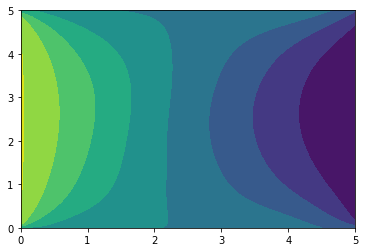

In [32]:
fig, ax = plt.subplots(1, 1)
ax.contourf(nx, ny, tt)